# Qubit Tapering 
### in the Stabilizer Subspace Projection formalism
Here, we take a look at the qubit reduction technique of [tapering](https://arxiv.org/abs/1701.08213) and an implementation based on the core `S3_projection` class. Unlike [Contextual-Subspace VQE](https://doi.org/10.22331/q-2021-05-14-456), this technique is *exact*, in the sense that it perfectly preserves the energy spectrum of the input operator.

At the core of qubit tapering is a symmetry of the Hamiltonian, which in this case means a set of universally commuting operators. The idea is that these operators must be simultaneously measureable and so can be treated independently of the remaining Hamiltonian terms. The method works by finding an independent generating set for the symmetry and seeks to find the 'correct' assignment of eigenvalues (called a *sector*), which completely determines the measurement outcome of the symmetry operators. Once this is obtained, the theory of stabilizers allows us to rotate the symmetry generators onto single Pauli $X$ operators, and since they must commute universally every operator of the rotated Hamiltonian will consist of an identity or Pauli $X$ in the corresponding qubit position. This means we can drop the qubit from the Hamiltonian, leaving in its place the eigenvalue determined by the chosen sector.

In [1]:
import numpy as np
import openfermion as of
import openfermionpyscf as ofpyscf
import qondense.utils.qonversion_tools as qonvert
from qondense.tapering import tapering
from qondense.utils.operator_toolkit import exact_gs_energy, plot_ground_state_amplitudes

First, we shall construct a molecule using OpenFermion with PySCF the underlying quantum chemistry package. The resulting fermionic operator will be mapped onto qubits via the Jordan-Wigner transformation.

In [2]:
# Two examples are provided -- comment out as necessary

# One for which Hartree-Fock identifies the correct symmetry sector...
#geometry=[
#    ("O",(0,0,0)),
#    ("H",(0.952519,0,0)),
#    ("H",(-0.246530058,0.9200627021,0))
#]

# ...and one for which it does not.
geometry=[
    ('H', (0.0,0.0,0.0)),
    ('H', (2.45366053071732,0.0,0.0)),
    ('H', (2.45366053071732,2.45366053071732,0.0)),
    ('H', (0.0,2.45366053071732,0.0))
     ]    
    
basis = 'sto-3g'
multiplicity = 1
charge = 0

molecule_data = of.MolecularData(geometry, basis, multiplicity, charge)
#molecule.load()

# Run pyscf.
molecule = ofpyscf.run_pyscf(molecule_data,
                     run_scf=1,run_mp2=1,run_cisd=1,run_ccsd=1,run_fci=1)

n_qubits    = 2*molecule.n_orbitals
n_electrons = molecule.n_electrons

ham_fermionic = of.get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_jw = of.jordan_wigner(ham_fermionic)

ham_dict = qonvert.QubitOperator_to_dict(ham_jw, n_qubits)

print('Jordan-Wigner Hamiltonian:\n\n', ham_dict)

Jordan-Wigner Hamiltonian:

 {'IIIIIIII': (-1.0811274948287173+0j), 'ZIIIIIII': (0.06459637602166574+0j), 'YZZZZZYI': (-0.014314043573277138+0j), 'XZZZZZXI': (-0.014314043573277138+0j), 'IZIIIIII': (0.06459637602166574+0j), 'IYZZZZZY': (-0.014314043573277133+0j), 'IXZZZZZX': (-0.014314043573277133+0j), 'IIZIIIII': (0.03757987407097262+0j), 'IIIZIIII': (0.03757987407097263+0j), 'IIIIZIII': (0.037579874070972644+0j), 'IIIIIZII': (0.0375798740709727+0j), 'IIIIIIZI': (0.013794448896003772+0j), 'IIIIIIIZ': (0.013794448896003779+0j), 'ZZIIIIII': (0.09088527438140584+0j), 'YIZZZZYI': (0.01366455328420774+0j), 'XIZZZZXI': (0.01366455328420774+0j), 'YXXYIIII': (0.01894231869971837+0j), 'YYXXIIII': (-0.01894231869971837+0j), 'XXYYIIII': (-0.01894231869971837+0j), 'XYYXIIII': (0.01894231869971837+0j), 'YXIIXYII': (0.05724315606459453+0j), 'YYIIXXII': (-0.05724315606459453+0j), 'XXIIYYII': (-0.05724315606459453+0j), 'XYIIYXII': (0.05724315606459453+0j), 'ZYZZZZZY': (0.01366455328420774+0j), 'ZXZZZ

In order to initialise our `tapering` class, we also need to supply a reference state, along with the molecular Hamiltonian. Under the Jordan-Wigner transformation, the Hartree-Fock state for our $M$-electron, $N$-orbital molecular system with charge=0 and multiplicity=1 will be 

$$|\mathrm{HF}\rangle = |\underbrace{1 \dots 1}_{M \,\text{times}}\; \underbrace{0 \dots 0}_{N-M \,\text{times}} \rangle.$$

Note that OpenFermion fills orbital occupations from the left... this will not always be the case! For example, if using Qiskit or some other quantum computing package the Hartree-Fock state will not look the same.

In [3]:
hf_state = [1 for i in range(n_electrons)]+[0 for i in range(n_qubits-n_electrons)]
hf_string = ''.join([str(i) for i in hf_state])
print(f'The Hartree-Fock state is |{hf_string}>')

The Hartree-Fock state is |11110000>


We are now in a position to initialize our `tapering` class, which will identify a set of independent operators that generate the Hamiltonian symmetry and the symmetry sector corresponding with the reference state (in this case Hartree-Fock). The sector is obtained by measuring each symmetry generator with respect to the reference state, yielding a $\pm1$ eigenvalue.

In [4]:
taper_hamiltonian = tapering(hamiltonian=ham_dict, 
                             ref_state=hf_state)

print(f'We are able to taper {taper_hamiltonian.n_taper} qubits from the Hamiltonian.')
print(f'The symmetry generators are {taper_hamiltonian.symmetry_ops}')
print(f'and the sector arising from the chosen reference state is {taper_hamiltonian.symmetry_sec}.')

We are able to taper 4 qubits from the Hamiltonian.
The symmetry generators are ['ZIIZIZZI', 'IZIZIZIZ', 'IIZZIIII', 'IIIIZZII']
and the sector arising from the chosen reference state is [1, 1, 1, 1].


This is everything we need to go ahead and perform the tapering process, which is effected by the `taper_it()` method that calls on the parent `S3_projection` class.

In [5]:
ham_tap = taper_hamiltonian.taper_it()._dict

print('Tapered Hamiltonian:\n\n', ham_tap)

Tapered Hamiltonian:

 {'IIII': -0.8483734323424035, 'XIII': -0.01894231869971837, 'IXII': -0.05724315606459453, 'XXII': 0.00014162735758915175, 'IIXI': -0.026382716791201008, 'XIXI': -0.03341063470396935, 'IXXI': 0.03455605614412895, 'IIIX': 0.026382716791201008, 'XIIX': 0.03341063470396935, 'IXIX': -0.03455605614412895, 'XIXX': -0.05927576188395211, 'IXXX': -0.02097492451907587, 'ZIII': 0.07515974814194526, 'IZII': 0.07515974814194534, 'ZZII': 0.3220696207523371, 'YYII': 0.00014162735758915175, 'ZZXI': 0.026382716791201008, 'ZZIX': -0.026382716791201008, 'IIZI': 0.013794448896003772, 'IIZX': 0.014314043573277133, 'ZIZI': 0.2846786045805779, 'ZXZI': 0.05724315606459453, 'YIYI': -0.03341063470396935, 'ZIZX': 0.040696760617242284, 'ZXZX': 0.03455605614412895, 'YIYX': -0.05927576188395211, 'IZZI': 0.238811430815654, 'XZZI': 0.01894231869971837, 'IYYI': 0.03455605614412895, 'IZZX': -0.040696760617242284, 'XZZX': -0.03341063470396935, 'IYYX': -0.02097492451907587, 'ZZZI': 0.064596376021665

We should also check that the ground state energy of the tapered Hamiltonian mathces that of the full system.

In [6]:
#print('Amplitude histogram for the ground state of the full system:')

true_gs_energy, true_gs_vec = exact_gs_energy(ham_dict)
tap_gs_energy, tap_gs = exact_gs_energy(ham_tap)

print(f'The ground state energy of the full system is {true_gs_energy},')
print(f'whereas for the tapered system we find the energy is {tap_gs_energy}.')
print(f'The absolute error is {tap_gs_energy-true_gs_energy}.')

The ground state energy of the full system is -1.8743108952541767,
whereas for the tapered system we find the energy is -1.8643897202426938.
The absolute error is 0.00992117501148293.


Do they match? Depending on the molecule chosen, they might not! One can sometimes find that the Hartree-Fock state does not yield the correct symmetry sector, particularly in the strongly correlated regime.

In [7]:
hf_vec = np.eye(1,len(true_gs_vec),int(hf_string,2))
hf_overlap = np.square(np.abs(hf_vec.dot(true_gs_vec)))[0]

if hf_overlap < 1e-18:
    print('The Hartree-Fock state has no overlap with the true ground state!')
else:
    print('The Hartree-Fock state exhibits non-zero overlap with the true ground state.')
print(f'Overlap of the Hartree-Fock state with the true ground state: <HF|True GS> = {hf_overlap:.10f}')

The Hartree-Fock state has no overlap with the true ground state!
Overlap of the Hartree-Fock state with the true ground state: <HF|True GS> = 0.0000000000


If we instead take the dominant basis state (plotted below in a histogram), we should see that the energies do match in the resulting sector...

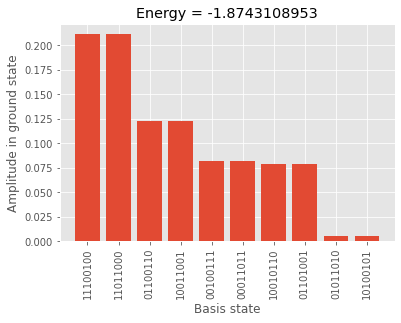

In the sector [1, 1, -1, -1], we find the ground state energy to be -1.874310895254168.
The absolute error is 4.884981308350689e-15.


In [8]:
amps, true_gs = plot_ground_state_amplitudes(ham_dict, n_qubits, return_amps=True)
taper_hamiltonian_2 = tapering(hamiltonian=ham_dict, 
                               ref_state=[int(i) for i in amps[0][0]])
ham_tap_2 = taper_hamiltonian_2.taper_it()._dict

tap_gs_energy_2, tap_gs_2 = exact_gs_energy(ham_tap_2)

print(f'In the sector {taper_hamiltonian_2.symmetry_sec}, we find the ground state energy to be {tap_gs_energy_2}.')
print(f'The absolute error is {tap_gs_energy_2-true_gs}.')

*The problem is...* 

we will not in general know how the basis states are distributed in the ground state!

The scalability of tapering is highly predicated on finding new approaches to identifying the correct symmetry sector.